# Robots do it again!

dr. Vasilescu calls her MARS-O-HELP robot to do its magic once more: The robot is capable of controlling its kinematics pretty reliably, so what if she makes it hold the antenna towards a communication satellite and follow its trajectory?

<img src="../artwork/stranded/robot_holding_satellite_dish.png" width=60% />

## First task
Using the code you constructed for the simulation in the [theory notebook for trajectories](../theory/lab06_Trajectories.ipynb), implement a line trajectory for the AL5D robot for the following starting and ending poses:
    
|Coord|Initial|Final|
|-|-|-|
|<td colspan=3>Position<td colspan=2>
|X|0.16|0.18|
|Y|0.22|-0.18|
|Z|0.09|0.13|
|<td colspan=3>Orientation (Euler 'zyx' angles) <td colspan=2>
|roll|0|0|
|pitch|20|-90|
|yaw|0|10|
    
Then, execute the trajectory using the robot on your desk

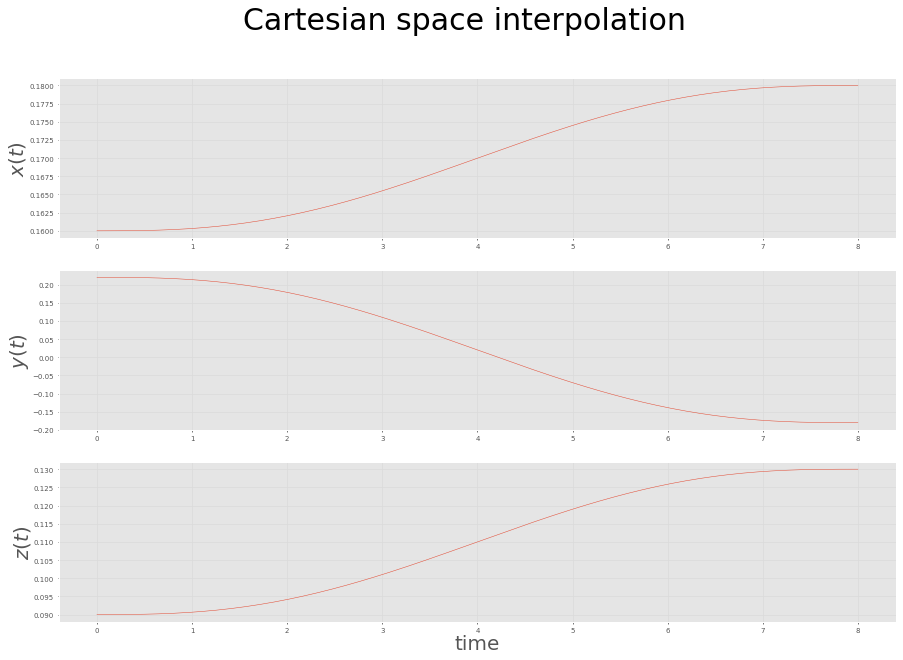

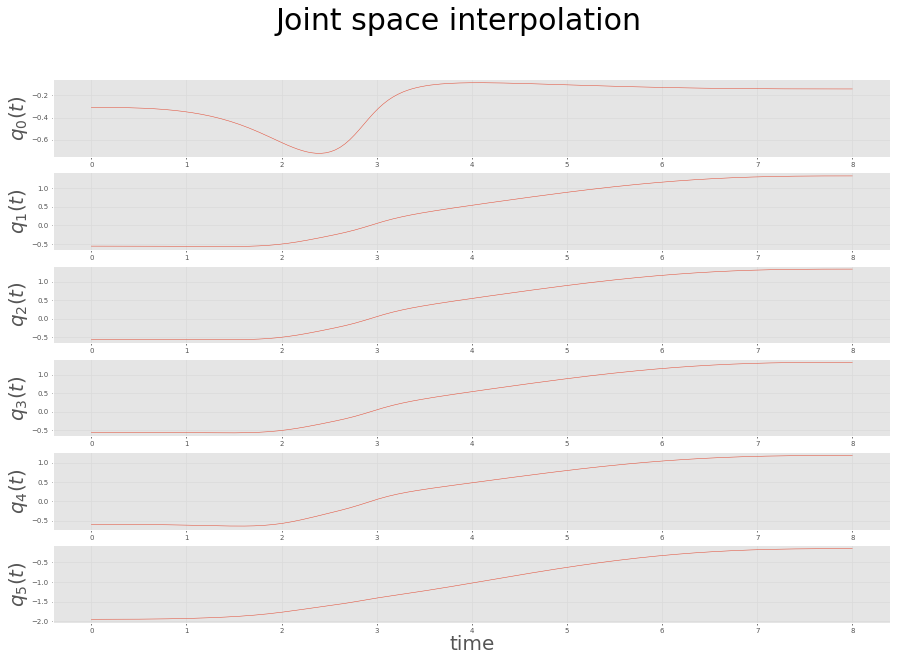

In [1]:
# You should only execute this cell once!
# If you execute it again, you need to restart the kernel and the robot
from al5d_control import *
from lab_functions import *
import swift

env = swift.Swift()
env.launch(realtime=True)

al5d = rtb.models.URDF.AL5D_mdw()
#al5d.q = al5d.qr

arrived = False
env.add(al5d)


def eef_pose(rs=0, re=0, ps=20, pe=-90, yas=0, yae=10, xs=0.16, xe=0.18, ys=0.22, ye=-0.18, zs=0.09, ze=0.13, T=8):
    dss, dse, ddss, ddse = 0,0,0,0
    steps = 20*T
    time = np.linspace(0,T,steps)
    timed = np.array((np.power(time,5),np.power(time,4),np.power(time,3),np.power(time,2),time,np.ones((steps,))))
    A = np.array([[0,0,0,0,0,1],[T**5, T**4, T**3,T**2, T, 1],[0,0,0,0,1,0],[5*T**4,4*T**3,3*T**2,2*T,1,0],[0,0,0,2,0,0],[20*T**3,12*T**2,6*T,2,0,0]])  
    inpt = np.array([0,1,dss,dse,ddss,ddse])
    inpt.shape = (6,1)
    sol = np.linalg.inv(A).dot(inpt)
    s = sol[0]*timed[0]+sol[1]*timed[1]+sol[2]*timed[2]+sol[3]*timed[3]+sol[4]*timed[4]+sol[5]*timed[5]
    x = (1-s)*xs+s*xe
    y = (1-s)*ys+s*ye
    z = (1-s)*zs+s*ze
    r = ((1-s)*rs+s*re)
    p = ((1-s)*ps+s*pe)
    ya = ((1-s)*yas+s*yae)
    
    x.shape = (steps,1)
    y.shape = (steps,1)
    z.shape = (steps,1)
    r.shape = (steps,1)
    p.shape = (steps,1)
    ya.shape = (steps,1)
    
    qs = np.zeros((steps,5))
    for i in range(steps):
        setpoint = SE3(x[i,0],y[i,0],z[i,0])*SE3.RPY([r[i,0],p[i,0],ya[i,0]], unit='deg')
        qs[i,:] = al5d.ikine_LM(setpoint, q0=qs[max(i-1,0),:]).q

    for i in range(steps):
        al5d.q = qs[i,:]
        env.step(0.05)
        
    plot_car_interpolation(time, x, y, z, 'Cartesian space interpolation')
    plot_joint_interpolation(time, qs[:,0], qs[:,1], qs[:,2], qs[:,3], qs[:,4],time, 'Joint space interpolation')

#interact_manual(eef_pose, rs=(-180,180), re=(-180,180), ps=(-180,180), pe=(-180,180), yas=(-180,180), yae=(-180,180), xs=(-0.9,0.9), xe=(-0.9,0.9), ys=(-0.9,0.9), ye=(-0.9,0.9), zs=(-0.9,0.9), ze=(-0.9,0.9), T=(1,10))
# for sending the commands
#rrob = AL5DControl()
eef_pose(rs=0, re=0, ps=20, pe=-90, yas=0, yae=10, xs=0.16, xe=0.18, ys=0.22, ye=-0.18, zs=0.09, ze=0.13, T=8)

In [ ]:
import time


T1  = SE3(0.16,0.22,0.09)@SE3.RPY(0,20,0, unit='deg')
T2  = SE3(0.18,-0.18,0.13)@SE3.RPY(0,-90,10, unit='deg')
steps = 100
tr = rtb.ctraj(T1,T2,steps)
qs = al5d.ikine_LM(tr).q

for i in range(steps):
    al5d.q = qs[i,:]
    env.step(0.05)

connection handler failed
Traceback (most recent call last):
  File "C:\Users\UTCN-C12\.conda\envs\rcs_labs\lib\site-packages\websockets\legacy\server.py", line 224, in handler
    await self.ws_handler(self, path)
  File "C:\Users\UTCN-C12\.conda\envs\rcs_labs\lib\site-packages\swift\SwiftRoute.py", line 134, in serve
    await self.expect_message(websocket, expected)
  File "C:\Users\UTCN-C12\.conda\envs\rcs_labs\lib\site-packages\swift\SwiftRoute.py", line 139, in expect_message
    recieved = await websocket.recv()
  File "C:\Users\UTCN-C12\.conda\envs\rcs_labs\lib\site-packages\websockets\legacy\protocol.py", line 552, in recv
    await self.ensure_open()
  File "C:\Users\UTCN-C12\.conda\envs\rcs_labs\lib\site-packages\websockets\legacy\protocol.py", line 929, in ensure_open
    raise self.connection_closed_exc()
websockets.exceptions.ConnectionClosedOK: received 1001 (going away); then sent 1001 (going away)


## Second task

Calculate a series of poses so that the robot follows a trajectory of a circle on the XY plane, with radius $r=6cm$, and centre at $ X = 20cm$, $Y = 0cm$, and $Z = 4cm$. The end-effector should not be rotated w.r.t. the base frame (0 rotations). Then solve the inverse kinematics for those poses and send the resulting joint coordinates on the robot.

In [4]:
import numpy as np
import roboticstoolbox as rtb
from spatialmath import SE3

# Parameters

radius = 0.06  # 6 cm
center_x = 0.20  # 20 cm
center_y = 0.0   # 0 cm
center_z = 0.04  # 4 cm

steps = 100

# Generate the circular trajectory

theta = np.linspace(0, 2*np.pi, steps)
x = center_x + radius * np.cos(theta)
y = center_y + radius * np.sin(theta)
z = np.full_like(x, center_z)

# Create the trajectory in SE3

tr = [SE3(xi, yi, zi) for xi, yi, zi in zip(x, y, z)]

# Compute inverse kinematics for each pose
# Assuming `al5d` is your robot model

qs = [al5d.ikine_LM(pose).q for pose in tr]

# Execute the trajectory

for q in qs:
    al5d.q = q
    env.step(0.05)  # Adjust the time step if necessary